# Exploración de datos

## Librerías

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from PyPDF2 import PdfReader
from pathlib import Path


import sys
root = Path().resolve().parent
sys.path.append(str(root))

from src.budget_buddy.utils.io import ensureDirs

In [2]:
manifest_path = Path("../data/processed/manifest_pdfs.csv")
df = pd.read_csv(manifest_path)
df.head()

,zip_root,year,block,pdf_relpath,pdf_filename,pdf_path,size_bytes,name_count,is_name_duplicate,first_seen_zip
0,2019_b6,2019,6,26A826E5-7C6A-463B-AAC6-A105C5F4B1EF.pdf,26A826E5-7C6A-463B-AAC6-A105C5F4B1EF.pdf,data/interim/unzipped_pdfs/2019_b6/26A826E5-7C...,3407,1,False,2019_b6
1,2019_b6,2019,6,501A5930-0AB1-40B7-A75E-5FA265AC575A.pdf,501A5930-0AB1-40B7-A75E-5FA265AC575A.pdf,data/interim/unzipped_pdfs/2019_b6/501A5930-0A...,3469,1,False,2019_b6
2,2019_b6,2019,6,506E5202-6161-406B-9D5E-39C82B126E92.pdf,506E5202-6161-406B-9D5E-39C82B126E92.pdf,data/interim/unzipped_pdfs/2019_b6/506E5202-61...,3397,1,False,2019_b6
3,2019_b6,2019,6,61DAC344-AC73-4A0D-B8F4-0BB17EFDA8A5.pdf,61DAC344-AC73-4A0D-B8F4-0BB17EFDA8A5.pdf,data/interim/unzipped_pdfs/2019_b6/61DAC344-AC...,3665,1,False,2019_b6
4,2019_b6,2019,6,7B05D070-5C97-4B43-AB0A-1364EFBC1966.pdf,7B05D070-5C97-4B43-AB0A-1364EFBC1966.pdf,data/interim/unzipped_pdfs/2019_b6/7B05D070-5C...,3473,1,False,2019_b6


## Total PDF's

In [3]:
len(df), df["pdf_filename"].nunique()

(608, 608)

## Conteo por año/bloque

In [4]:
df.groupby("year")["pdf_filename"].nunique().reset_index(name="n_pdfs")


,year,n_pdfs
0,2019,9
1,2020,64
2,2021,94
3,2022,89
4,2023,127
5,2024,123
6,2025,102


In [5]:
df.groupby(["year", "block"])["pdf_filename"].nunique() \
  .reset_index(name="n_pdfs") \
  .sort_values(["year", "block"])


,year,block,n_pdfs
0,2019,6,9
1,2020,1,10
2,2020,2,8
3,2020,3,13
4,2020,4,11
5,2020,5,7
6,2020,6,15
7,2021,1,14
8,2021,2,12
9,2021,3,18


# Tamaños de archivo

In [6]:
df["size_mb"] = df["size_bytes"] / (1024 * 1024)
df["size_mb"].describe()

count    608.000000
mean       0.003588
std        0.000502
min        0.003208
25%        0.003366
50%        0.003501
75%        0.003637
max        0.008304
Name: size_mb, dtype: float64

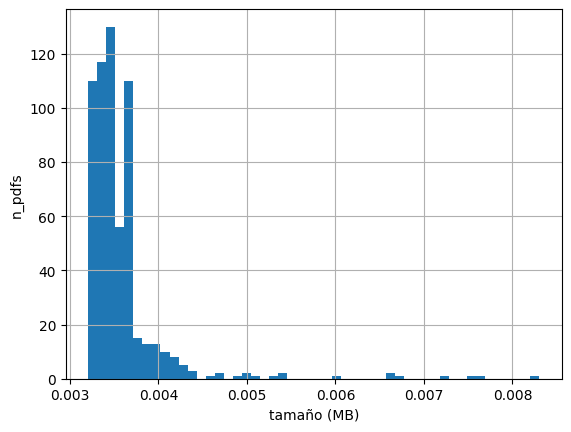

In [7]:
df["size_mb"].hist(bins=50)
plt.xlabel("tamaño (MB)")
plt.ylabel("n_pdfs")
plt.show()

## Duplicados

In [8]:
dups_path = Path("../data/processed/manifest_duplicates.csv")
dups = pd.read_csv(dups_path)
dups.head()

,pdf_filename,zip_root,year,block,size_bytes,pdf_path,first_seen_zip,is_name_duplicate


In [9]:
dups["pdf_filename"].value_counts().head(20)

Series([], Name: count, dtype: int64)

In [10]:
if "sha256" in dups.columns:
    dups["sha256"].value_counts().head(20)

## Conteo por categoría

In [11]:
cats_path = Path("../data/processed/categories.csv")
cats = pd.read_csv(cats_path)
cats.head()

,pdf_path,pdf_filename,category,updated_at,missing
0,data/interim/unzipped_pdfs/2024_b1/00296E01-F0...,00296E01-F063-4839-BBD7-E987331D8968.pdf,finanzas,2025-11-05T16:22:59.929763,0
1,data/interim/unzipped_pdfs/2024_b2/018466C0-09...,018466C0-09A0-41EC-BD24-7A9E0486F7FD.pdf,servicios_seguros,2025-11-05T16:23:46.883915,0
2,data/interim/unzipped_pdfs/2024_b5/01BBC5DB-15...,01BBC5DB-1514-4D85-8F73-E5B8DC4D83D4.pdf,compras_electronicos,2025-11-08T22:20:42.272728,0
3,data/interim/unzipped_pdfs/2023_b6/01F6F37F-1F...,01F6F37F-1F64-4EA9-AB56-D6EE64AB1155.pdf,finanzas,2025-11-08T22:25:53.079848,0
4,data/interim/unzipped_pdfs/2020_b4/022FB29E-41...,022FB29E-412A-4F85-BA5B-309E3B79DDEE.pdf,compras_electronicos,2025-11-08T22:27:45.649799,0


In [12]:
cats[cats["missing"] == 0] \
    .groupby("category")["pdf_filename"] \
    .nunique() \
    .reset_index(name="n_pdfs") \
    .sort_values("n_pdfs", ascending=False)

,category,n_pdfs
8,servicios_seguros,172
1,compras_electronicos,78
7,servicios_internet_telefonia,66
6,salud,61
2,compras_personales,43
10,transporte,40
9,supermercados,39
0,alimentacion_restaurantes,34
3,finanzas,34
4,hogar,24


## Cruces de data

In [13]:
valid = cats[cats["missing"] == 0].copy()
cats_year = valid.merge(df[["pdf_path", "year"]], on="pdf_path", how="left")

cats_year.groupby(["year", "category"])["pdf_filename"] \
    .nunique() \
    .reset_index(name="n_pdfs") \
    .sort_values(["year", "category"])

,year,category,n_pdfs
0,2019,compras_electronicos,1
1,2019,compras_personales,1
2,2019,servicios_internet_telefonia,2
3,2019,servicios_seguros,3
4,2019,transporte,2
...,...,...,...
60,2025,salud,20
61,2025,servicios_internet_telefonia,6
62,2025,servicios_seguros,22
63,2025,supermercados,11


In [14]:
tables_dir = Path("outputs/tables")
ensureDirs([tables_dir])

cats_year_counts = cats_year.groupby(["year", "category"])["pdf_filename"] \
    .nunique() \
    .reset_index(name="n_pdfs") \
    .sort_values(["year", "category"])

cats_year_counts.to_csv(tables_dir / "cats_year_counts.csv", index=False)

## Exploración por PDF

In [15]:
def countPages(pdf_path):
    try:
        reader = PdfReader(str(pdf_path))
        return len(reader.pages)
    except Exception:
        return None

df["n_pages"] = df["pdf_path"].apply(lambda p: countPages(Path(p)))
df["n_pages"].describe()

count       0
unique      0
top       NaN
freq      NaN
Name: n_pages, dtype: object